In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import os, sys

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
sys.path.append(os.path.expanduser("~/Dropbox/ROZ/code/pyCRM"))
from pyCRM import CRM

sns.set()
DATA_DIR = "../data/"

In [3]:
inj = pd.read_csv(DATA_DIR + "injection_Senlac.csv")
prod = pd.read_csv(DATA_DIR + "production_Senlac.csv")
injection = inj.values
production = prod.values
time = pd.read_csv(DATA_DIR + "time_Senlac.csv").values[:, 0]

[Text(0.5, 1.0, 'Correlation matrix')]

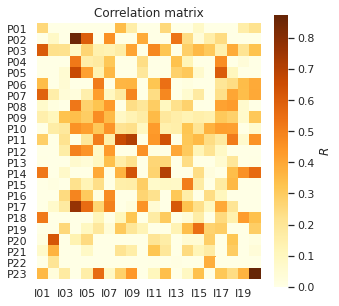

In [4]:
cor_matrix = prod.join(inj).corr().loc[lambda x: x.index.str.contains('P'), lambda y: y.index.str.contains('I')]

s = 5
plt.figure(figsize=(s,s))
g = sns.heatmap(cor_matrix, vmin=0, cmap='YlOrBr', cbar_kws={'label':'$R$'}, square=True)
g.set(title='Correlation matrix')

# Random forest

In [5]:
from sklearn.ensemble import RandomForestRegressor

In [6]:
inj_withlags = inj.join(inj.shift(1).fillna(0).rename(columns=lambda x: x + '_lag1')).join(inj.shift(2).fillna(0).rename(columns=lambda x: x + '_lag2'))
inj_withlags.head()

,I01,I02,I03,I04,I05,I06,I07,I08,I09,I10,...,I11_lag2,I12_lag2,I13_lag2,I14_lag2,I15_lag2,I16_lag2,I17_lag2,I18_lag2,I19_lag2,I20_lag2
0,32450.6,0.0,27280.2,24959.1,0.0,26086.32,11347.36,36023.4,0.0,19700.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,27487.7,0.0,24235.8,20902.0,0.0,23474.64,8126.80,22776.4,0.0,18706.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26468.7,0.0,28770.9,25323.9,0.0,26217.12,12529.84,25758.0,0.0,21053.0,...,0.0,27141.8,32362.6,2245.6,17549.4,14322.6,16052.3,20946.0,43596.7,28230.0
3,19794.9,0.0,28380.9,19260.3,0.0,23343.84,11483.20,19939.6,0.0,21285.7,...,0.0,22134.9,25852.3,2541.2,11007.7,10611.4,8315.5,16712.8,30821.5,23091.0
4,29009.9,0.0,30481.8,17071.3,0.0,23535.04,11216.48,25902.6,0.0,21606.5,...,0.0,26600.8,29041.4,7611.0,10347.2,13511.1,17555.7,20260.4,36199.5,26097.6


In [7]:
%%time
reg = RandomForestRegressor(n_estimators=250, min_samples_split=10, max_features='sqrt', n_jobs=2)

connectivities = pd.DataFrame(index=inj_withlags.columns, columns=prod.columns)
for p in prod.columns:
    reg.fit(inj_withlags, prod[p])
    connectivities[p] = pd.Series(reg.feature_importances_, index=inj_withlags.columns)

CPU times: user 11.1 s, sys: 1.01 s, total: 12.1 s
Wall time: 9.75 s


In [8]:
s = 5
conn_lag = connectivities.groupby(connectivities.index.str[:3])
conn_lag.std()

,P01,P02,P03,P04,P05,P06,P07,P08,P09,P10,...,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23
I01,0.000264,0.001718,0.022622,0.002106,0.001110,0.002113,0.003250,0.001860,0.003373,0.002829,...,0.008753,0.004739,0.004122,0.001564,0.014865,0.003673,0.001549,0.003835,0.006663,0.005837
I02,0.000321,0.000168,0.001383,0.001373,0.001412,0.002236,0.001099,0.000911,0.002706,0.002262,...,0.001310,0.000208,0.002261,0.001010,0.002404,0.003253,0.023003,0.006918,0.002361,0.000967
I03,0.000469,0.001762,0.002064,0.006764,0.004786,0.001417,0.001334,0.004098,0.021540,0.004083,...,0.000822,0.001562,0.004357,0.008741,0.005081,0.006565,0.003601,0.000647,0.001035,0.002837
I04,0.009700,0.018463,0.000806,0.007525,0.008448,0.006463,0.000880,0.008355,0.004064,0.004308,...,0.001479,0.010919,0.004103,0.013741,0.002167,0.000928,0.003475,0.003048,0.002068,0.002058
I05,0.006942,0.010850,0.002845,0.001692,0.001630,0.002021,0.002615,0.003532,0.004268,0.003406,...,0.002128,0.000978,0.003760,0.004584,0.002398,0.002520,0.003403,0.003228,0.000882,0.000895
I06,0.000971,0.000683,0.002562,0.001726,0.000293,0.021804,0.009007,0.006916,0.026652,0.004750,...,0.001064,0.001980,0.001057,0.001987,0.009731,0.011263,0.002296,0.005448,0.004504,0.018411
I07,0.015990,0.012743,0.003035,0.004292,0.002045,0.000439,0.000719,0.006954,0.012456,0.008655,...,0.002387,0.001639,0.010976,0.009870,0.006277,0.002194,0.002193,0.003960,0.000739,0.001169
I08,0.001280,0.002262,0.002131,0.000569,0.002447,0.002347,0.004365,0.001460,0.001433,0.000105,...,0.004545,0.003658,0.004630,0.000673,0.001767,0.003438,0.001778,0.004811,0.001048,0.008601
I09,0.000857,0.000868,0.013945,0.002499,0.000630,0.005070,0.004552,0.002899,0.001046,0.004306,...,0.015861,0.006538,0.000792,0.000858,0.003894,0.002076,0.001141,0.002940,0.006448,0.002759
I10,0.003523,0.003465,0.001617,0.001684,0.002155,0.002789,0.001768,0.000030,0.002157,0.001395,...,0.001297,0.010620,0.002773,0.008673,0.011505,0.000736,0.005562,0.003014,0.002164,0.000662


[Text(0.5, 1.0, 'Random forest connectivity')]

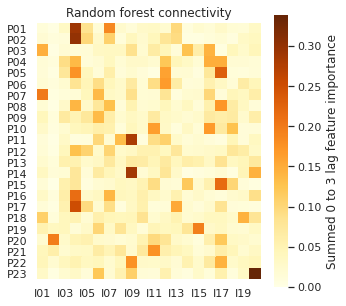

In [9]:
plt.figure(figsize=(s,s))
g = sns.heatmap(conn_lag.sum().T, vmin=0, cmap='YlOrBr', cbar_kws={'label':'Summed 0 to 3 lag feature importance'}, square=True)
g.set(title='Random forest connectivity')

In [10]:
CRM??

Init signature:
CRM(
    primary: bool = True,
    tau_selection: str = 'per-pair',
    constraints: str = 'positive',
)
Source:        
class CRM():
    """A Capacitance Resistance Model history matcher

    CRM uses a physics-inspired mass balance approach to explain production for waterfloods.
    It treants each injector-producer well pair as a system with mass input, output, and pressure
    related to the mass balance. Several versions exist. For an exhaustive review, check
    "A State-of-the-Art Literature Review on Capacitance Resistance Models for Reservoir
    Characterization and Performance Forecasting" - Holanda et al., 2018.

    Args
    ----------
    primary (bool): Whether to model primary production (strongly recommended)
    tau_selection (str): How many tau values to select
        - If 'per-pair', fit tau for each producer-injector pair
        - If 'per-producer', fit tau for each producer (CRMp model)
    constraints (str): How to constrain the gains
        - 

In [ ]:
%%time 
constrainer = "up-to one"
crm_rf = CRM(primary=True, constraints=constrainer, tau_selection="per-pair")
crm_rf.set_rates(production, injection, time)
gains_rf = conn_lag.sum().T.stack().values
initial_guess = np.concatenate([gains_rf/20, crm_rf._get_initial_guess()[len(gains_rf):]])

N_p, N_i = production.shape[1], injection.shape[1]
#crm_rf.set_connections(gains=gains_rf.reshape((N_p, N_i))/20, tau=30.0*np.ones((N_p, N_i)), gains_producer=np.zeros(N_p), tau_producer=30*np.ones(N_p))

crm_rf.fit(
    production,
    injection,
    time,
    initial_guess=initial_guess,
    method="Powell",
    options={"disp": True, "maxiter": 1000}
)

pred = crm_rf.predict()
fig, axes = plt.subplots(production.shape[1]//2+1, 2, figsize=(8,N_p*1.5), sharey=True)
axes = axes.flatten()
for i in range(N_p):
    axes[i].plot(time/365.24, production[:,i], '-', label='production')
    axes[i].plot(time/365.24, pred[:,i], '--', label='fit')
    if i % 2 == 0:
        axes[i].set(xlabel='Time (y)', ylabel='Rate (bbl/m)')
    axes[i].legend()
fig.tight_layout()

In [ ]:
gains_rf_fit = pd.DataFrame(crm_rf.gains, index=prod.columns, columns=inj.columns)
sns.heatmap(gains_rf_fit, vmin=0, cmap='YlOrBr')

In [ ]:
gains_rf_fit.to_csv('../results/gain_from_RF_fitted.csv')

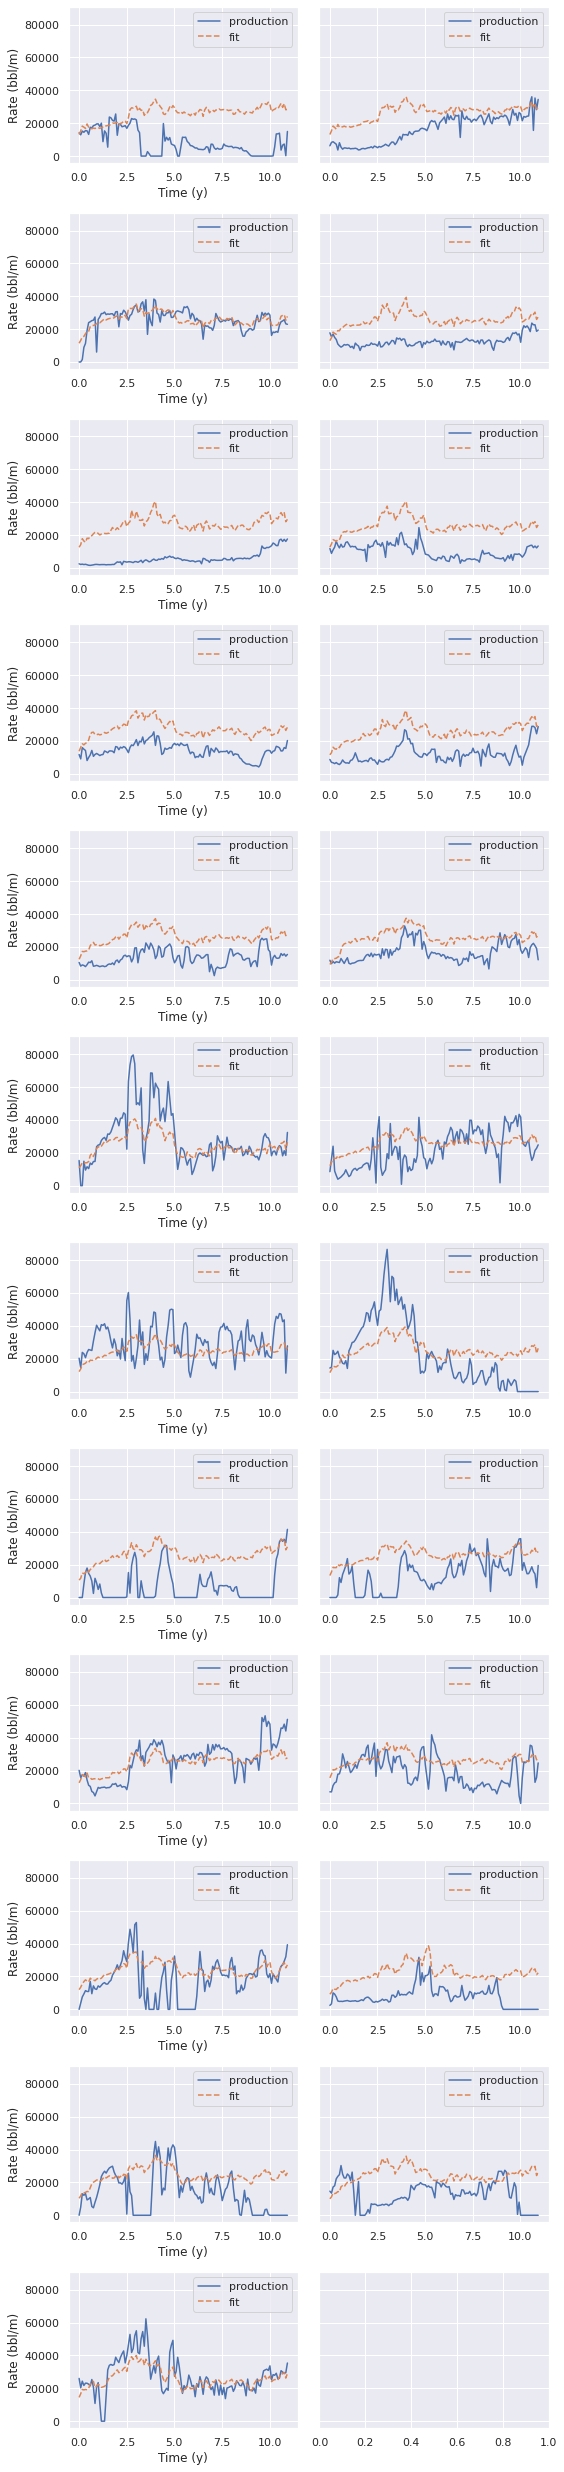

In [35]:
crm_rf = CRM(primary=True, constraints=constrainer, tau_selection="per-pair")
crm_rf.set_rates(production, injection, time)
gains_rf = conn_lag.sum().T.stack().values
initial_guess = np.concatenate([gains_rf/20, crm_rf._get_initial_guess()[len(gains_rf):]])

N_p, N_i = production.shape[1], injection.shape[1]
crm_rf.set_connections(gains=gains_rf.reshape((N_p, N_i))/20, tau=30.0*np.ones((N_p, N_i)), gains_producer=np.zeros(N_p), tau_producer=30*np.ones(N_p))

pred = crm_rf.predict()
fig, axes = plt.subplots(production.shape[1]//2+1, 2, figsize=(8,N_p*1.5), sharey=True)
axes = axes.flatten()
for i in range(N_p):
    axes[i].plot(time/365.24, production[:,i], '-', label='production')
    axes[i].plot(time/365.24, pred[:,i], '--', label='fit')
    if i % 2 == 0:
        axes[i].set(xlabel='Time (y)', ylabel='Rate (bbl/m)')
    axes[i].legend()
fig.tight_layout()

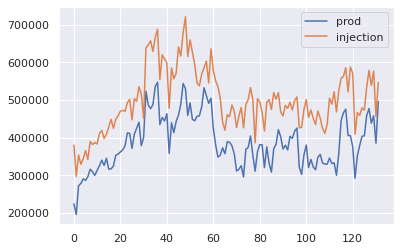

In [75]:
prod.sum(1).plot(label='prod')
inj.sum(1).plot(label='injection')
plt.legend()

In [23]:
reg.score(injection, production)

0.7203652483946792

In [26]:
from sklearn.inspection import permutation_importance


I01    0.035469
I02    0.015927
I03    0.026672
I04    0.097521
I05    0.048827
I06    0.083261
I07    0.053819
I08    0.039142
I09    0.121546
I10    0.031103
I11    0.054098
I12    0.066160
I13    0.054619
I14    0.021578
I15    0.027827
I16    0.029190
I17    0.040783
I18    0.027671
I19    0.033967
I20    0.090821
dtype: float64

In [25]:
production

array([[14138.4,  6255.7,     0. , ...,     0. , 14668.7, 26036.6],
       [12921.8,  8312.8,     0. , ...,  4983.6, 13467.1, 20300.9],
       [15197.6,  8736.6,  1485.8, ..., 13086.5, 17174.6, 24358.6],
       ...,
       [ 7325.5, 35344.8, 25727.4, ...,     0. ,     0. , 29198.3],
       [  234. , 28269.7, 23228.3, ...,     0. ,     0. , 29518.4],
       [14966.8, 34477.4, 22950.2, ...,     0. ,     0. , 35399.7]])